# Image classification MNIST using tensorflow

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print ('tf:', tf.__version__)
print("Num GPUs Available:",len(tf.config.experimental.list_physical_devices('GPU')))

tf: 2.2.0
Num GPUs Available: 1


## load data

In [2]:
#%% Get the data as Numpy arrays from built-in keras.datasets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_test_orig = x_test 
y_test_integer = y_test # keep for evaluating prediction
print(type(x_train))
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

<class 'numpy.ndarray'>
(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)


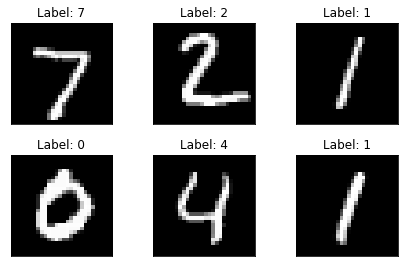

In [3]:
#%% show some samples
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    tmp = x_test[i]
    print(tmp.shape)
    plt.imshow(tmp, cmap='gray', interpolation='none')
    plt.title("Label: {}".format(y_test[i]))
    plt.xticks([])
    plt.yticks([])

In [4]:
#%% reshape data: (x_train, y_train), (x_test, y_test)
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
    
# convert to one-hot class label
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

print(x_test.shape)
print(y_test.shape)

(10000, 28, 28, 1)
(10000, 10)


In [5]:
# for train option (B): using iterator as data input
batch_size = 128 # how many samples to fetch each time from dataset
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)
type(dataset)

# enumerate wraps any iterator with a lazy generator
examples = enumerate(dataset)
print(type(examples))

batch_idx, (example_data, example_targets) = next(examples)
print(batch_idx, example_data.shape)
print(batch_idx, example_targets.shape)

<class 'enumerate'>
0 (128, 28, 28, 1)
0 (128, 10)


## building the model

In [6]:
num_classes = 10

# (A) baseline model: MLP
# inputs = keras.Input(shape=(28, 28))
# x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
# x = layers.Flatten()(x)
# x = layers.Dense(128, activation="relu")(x)
# x = layers.Dense(128, activation="relu")(x)
# outputs = layers.Dense(num_classes, activation="softmax")(x)

# (B) one conv layer network
# inputs = keras.Input(shape=(28, 28, 1))
# x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
# x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(x)
# x = layers.MaxPooling2D(pool_size=(2, 2))(x)
# x = layers.Dropout(.25)(x)
# x = layers.Flatten()(x)
# x = layers.Dense(128, activation="relu")(x)
# x = layers.Dropout(.5)(x)
# outputs = layers.Dense(num_classes, activation="softmax")(x)

# (C) LeNet5 (with kenel=5) for the reduced-size MNIST (28*28) from original size (32*32) in the paper
inputs = keras.Input(shape=(28, 28, 1)) # 1 is needed here to keep the same dim with next conv2D layer
x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
x = layers.Conv2D(filters=6, kernel_size=(5, 5), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=16, kernel_size=(5, 5), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(120, activation="relu")(x)
x = layers.Dense(84, activation="relu")(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)


# (D) a deeper CNN model (~50k para): slightly better perf. than above
# inputs = keras.Input(shape=(28, 28, 1)) # 1 is needed here to keep the same dim with next conv2D layer
# x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
# x = layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation="relu")(x)
# x = layers.MaxPooling2D(pool_size=(3, 3), strides=(3, 3))(x)
# x = layers.Dropout(.2)(x)
# x = layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation="relu")(x)
# x = layers.MaxPooling2D(pool_size=(3, 3), strides=(3, 3))(x)
# x = layers.Dropout(.2)(x)
# x = layers.Flatten()(x)
# x = layers.Dense(128, activation="relu")(x) # <<<<<<<<
# x = layers.Dropout(.2)(x)
# outputs = layers.Dense(num_classes, activation="softmax")(x)

In [7]:
model = keras.Model(inputs, outputs)
# show model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 24, 24, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 16)          2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0     

## compile the model 

NOTE: in model.compile(), ... tf.keras.metrics=['accuracy'], ... 
the term “accuracy” is an expression, to let the training file decide which 
metric should be used (binary accuracy, categorial accuracy or sparse categorial 
accuracy). This decision is based on certain parameters like the output shape 
(the shape of the tensor that is produced by the layer and that will be the 
input of the next layer) and the loss functions.



In [8]:
## (A) single integers as class lables (Don't convert Y to one-hot class label in this case)
# model.compile(
#     optimizer="adam",
#     loss="sparse_categorical_crossentropy", #or, loss= keras.losses.SparseCategoricalCrossentropy(),
#     metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
#     )

## (B) one-hot class lable, loss & metrics differ  
model.compile(
    optimizer="adam",
    loss='categorical_crossentropy',   # one-hot class lable 
    metrics= [tf.keras.metrics.CategoricalAccuracy(name ="acc")],# "acc" for picking data from dict
    ) # 'metrics.Accuracy' will yield extremly low acc due to directly compare y and y_hat

callbacks = [keras.callbacks.TensorBoard(log_dir='./logs')] # for using TensorBoard
# Launch TensorBoard from the command line: tensorboard --logdir= path_to_your_logs


## train the model 

In [9]:
N_epoch = 10
start_time = time.time()

# (A) Train the model from Numpy data
# history = model.fit(x_train, y_train, validation_data= (x_test, y_test), 
#                     batch_size=batch_size, epochs=N_epoch, callbacks=callbacks)

# (B) Train the model using iterater
history = model.fit(dataset, epochs= N_epoch, validation_data = val_dataset)
# history = model.fit(dataset, epochs= N_epoch, validation_data = val_dataset, callbacks=callbacks)

print('elapsed_time:',  time.time() - start_time)

Epoch 1/10
469/469 [==============================] - 3s 7ms/step - loss: 0.3523 - acc: 0.8991 - val_loss: 0.1072 - val_acc: 0.9651
Epoch 2/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0970 - acc: 0.9704 - val_loss: 0.0693 - val_acc: 0.9779
Epoch 3/10
469/469 [==============================] - 3s 7ms/step - loss: 0.0658 - acc: 0.9802 - val_loss: 0.0567 - val_acc: 0.9820
Epoch 4/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0522 - acc: 0.9839 - val_loss: 0.0449 - val_acc: 0.9850
Epoch 5/10
469/469 [==============================] - 3s 7ms/step - loss: 0.0432 - acc: 0.9868 - val_loss: 0.0416 - val_acc: 0.9860
Epoch 6/10
469/469 [==============================] - 3s 7ms/step - loss: 0.0362 - acc: 0.9888 - val_loss: 0.0393 - val_acc: 0.9874
Epoch 7/10
469/469 [==============================] - 3s 7ms/step - loss: 0.0308 - acc: 0.9907 - val_loss: 0.0374 - val_acc: 0.9882
Epoch 8/10
469/469 [==============================] - 3s 7ms/step - loss: 0.

## Evaluate

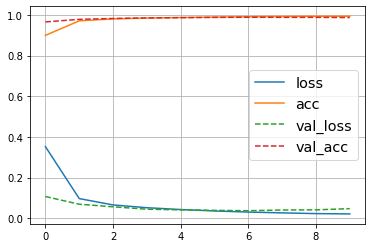

In [10]:
# plot training process
hist_dict = history.history
fig = plt.figure
plt.plot(hist_dict['loss'],label='loss',linestyle='-')
plt.plot(hist_dict['acc'],label='acc',linestyle='-')
plt.plot(hist_dict['val_loss'],label='val_loss',linestyle='--')
plt.plot(hist_dict['val_acc'],label='val_acc',linestyle='--')
plt.legend(loc='best', fontsize='x-large')
plt.grid(True)

In [11]:
#%% evaluate & predict
# loss, acc = model.evaluate(val_dataset)  # returns loss and metrics
loss, acc = model.evaluate(x_test, y_test)
print("loss: %.2f" % loss)
print("acc: %.2f" % acc)

# predictions = model.predict(val_dataset)
predictions = model.predict(x_test)
y_pred = np.argmax(predictions, axis=1)

y_incorrects_index = np.nonzero(y_pred!= y_test_integer)[0]
print('the total number of incorrect preditions', len(y_incorrects_index))


313/313 [==============================] - 1s 3ms/step - loss: 0.0476 - acc: 0.9865
loss: 0.05
acc: 0.99
the total number of incorrect preditions 135


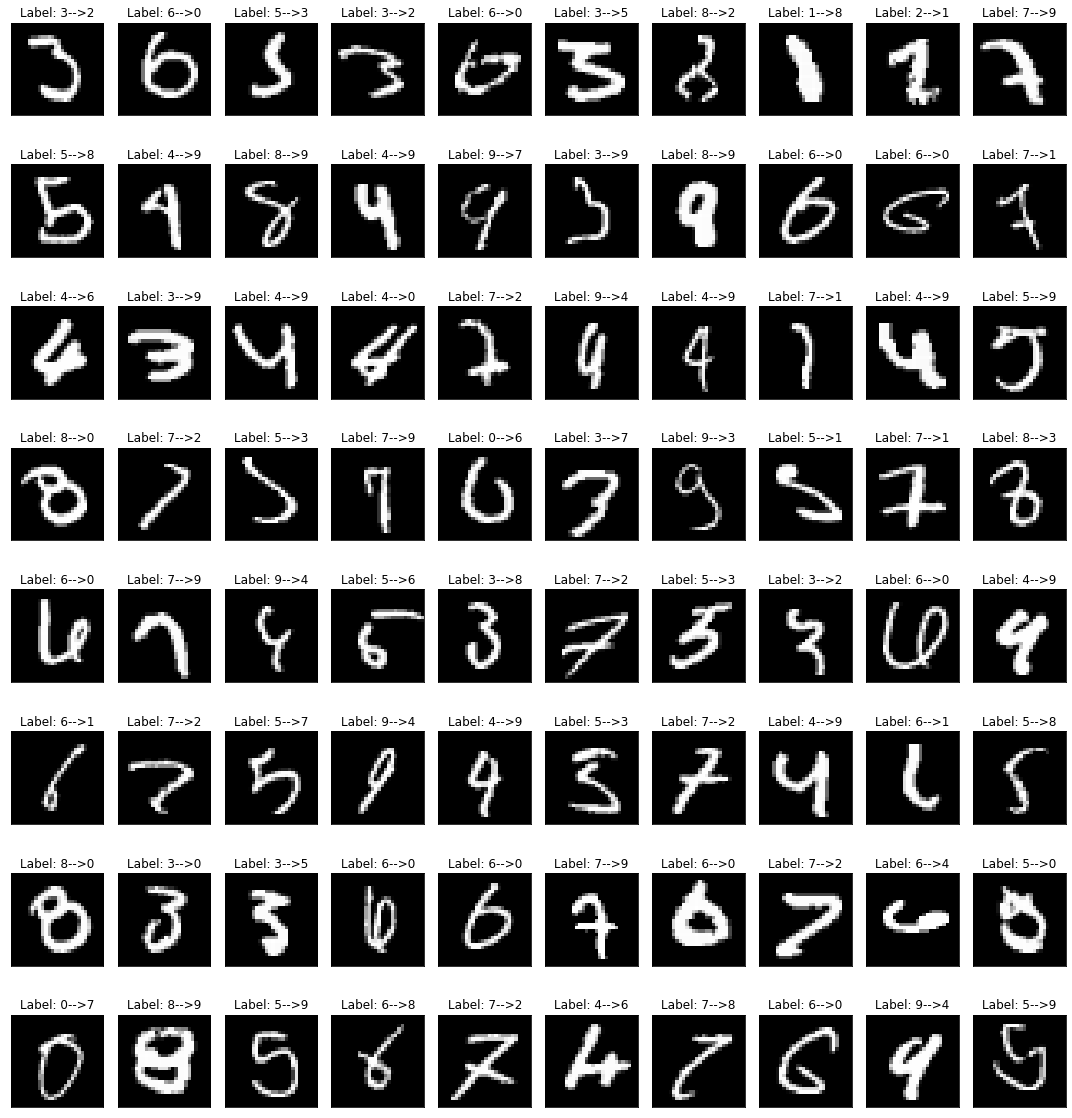

In [12]:
#%% show first 80 wrong samples
num = len(y_incorrects_index)
images = x_test_orig[y_incorrects_index[:num]]
labels = y_test_integer[y_incorrects_index[:num]]
preds = y_pred[y_incorrects_index[:num]]
num_row = 8
num_col = 10

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
N2plt = min([num_row*num_col, num])
for i in range(N2plt):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}-->{}'.format(labels[i], preds[i]))
    ax.set_xticks([]) # no show ticks
    ax.set_yticks([])
plt.tight_layout()
plt.show()


Digit = 3
Predicted Digit = 2


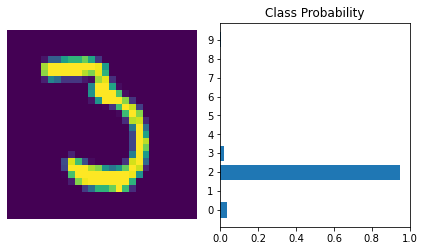

In [17]:
#%% plot predict outputs (probability) for each class
def view_classify(img, ps):
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img)
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1)
    plt.tight_layout()
    
#%%    
id = 0 # check a wrong classified image
img = x_test_orig[y_incorrects_index[id]]
y  = y_test_integer[y_incorrects_index[id]]
p  = predictions[y_incorrects_index[id]]
prob10 = list(p)
print("Digit =", y)
print("Predicted Digit =", prob10.index(max(prob10)))
view_classify(img, p)